The objective of this dataset is to build a predictive model for diagnosing diabetes in female patients who are at least 21 years old and of Pima Indian heritage. The model should predict whether a patient has diabetes (Outcome = 1) or does not have diabetes (Outcome = 0) based on several diagnostic measurements, including glucose level, blood pressure, skin thickness, insulin level, BMI, diabetes pedigree function, and age.

In [34]:
#Importing Libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [35]:
# Load dataset
df = pd.read_csv("diabetes.csv")  
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Explore The Data  :    Correlation between attributes: Correlation Heatmap using seaborn
Distributions of attributes: Distribution plots for Glucose, BMI, etc.
Boxplots to detect outliers



In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [37]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [38]:
# to print top 5 records of data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


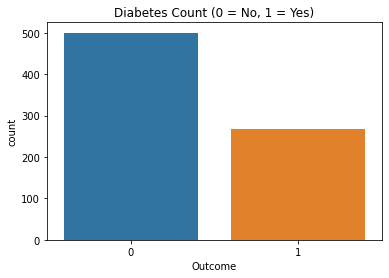

In [39]:
sns.countplot(x='Outcome', data=df)
plt.title("Diabetes Count (0 = No, 1 = Yes)")
plt.show()

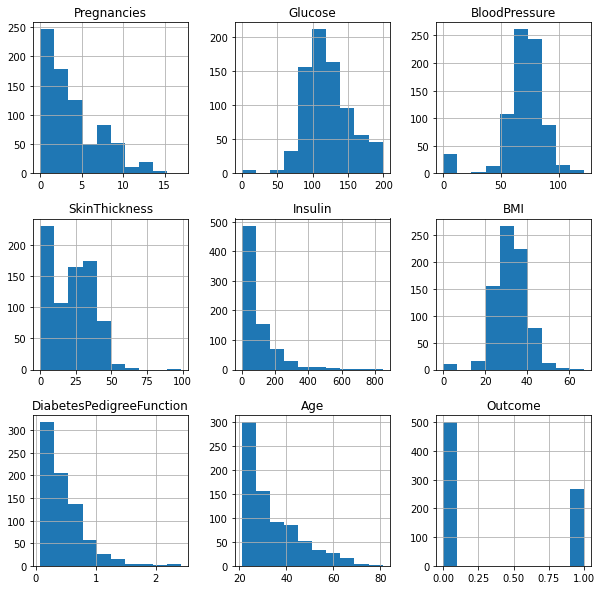

In [40]:
df.hist(figsize = (10,10))
plt.show()

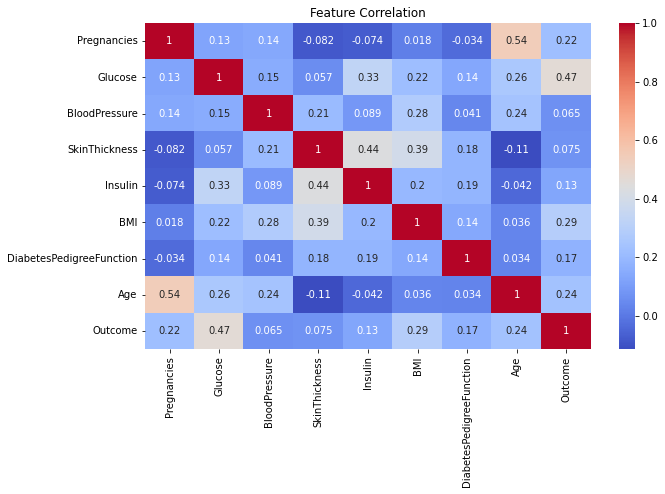

In [41]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [42]:
hig_corr = df.corr()
hig_corr_features = hig_corr.index[abs(hig_corr["Outcome"]) >= 0.2]
hig_corr_features

Index(['Pregnancies', 'Glucose', 'BMI', 'Age', 'Outcome'], dtype='object')

In [43]:
#to check the variance (Will be able to see Outliers)
df.var()

Pregnancies                    11.354056
Glucose                      1022.248314
BloodPressure                 374.647271
SkinThickness                 254.473245
Insulin                     13281.180078
BMI                            62.159984
DiabetesPedigreeFunction        0.109779
Age                           138.303046
Outcome                         0.227483
dtype: float64

1. Insulin shows extremely high variance (13,281), indicating the presence of significant outliers.
2. Glucose, BloodPressure, and SkinThickness also have relatively high variance but within a more acceptable range.
3. DiabetesPedigreeFunction has very low variance (0.11), indicating the values are closely clustered.

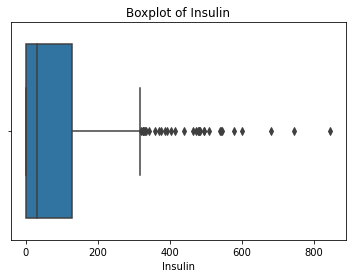

In [44]:
# Plot for Insulin
sns.boxplot(x=df["Insulin"])
plt.title("Boxplot of Insulin")
plt.show()

In [45]:
#Handling Outlier
df_clean = df.copy()
numeric_columns = ['Insulin', 'DiabetesPedigreeFunction',]

for column_name in numeric_columns:
    Q1 = np.percentile(df_clean[column_name], 25, interpolation='midpoint')
    Q3 = np.percentile(df_clean[column_name], 75, interpolation='midpoint')

    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR

    # Find outliers in the specified column
    outliers = df_clean[(df_clean[column_name] < low_lim) | (df_clean[column_name] > up_lim)][column_name]

    # Replace outliers with the respective lower or upper limit
    df_clean[column_name] = np.where(df_clean[column_name] < low_lim, low_lim, df_clean[column_name])
    df_clean[column_name] = np.where(df_clean[column_name] > up_lim, up_lim, df_clean[column_name])

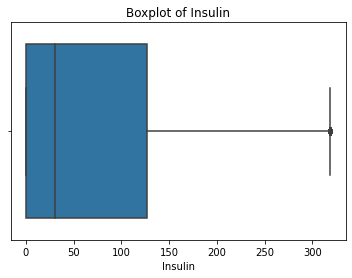

In [46]:
# Plot for Insulin after cleaning
sns.boxplot(x=df_clean["Insulin"])
plt.title("Boxplot of Insulin")
plt.show()

In [54]:
X = df_clean.drop('Outcome', axis = 1)
y = df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20)

In [55]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=200)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy: 77.69%


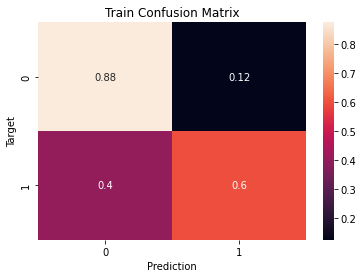

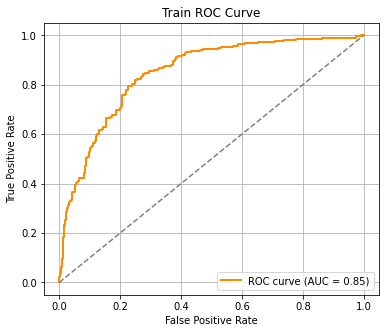

Accuracy: 77.27%


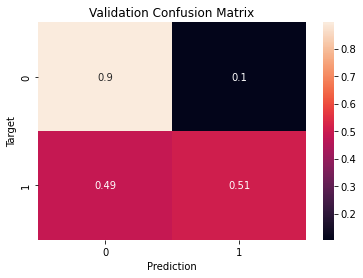

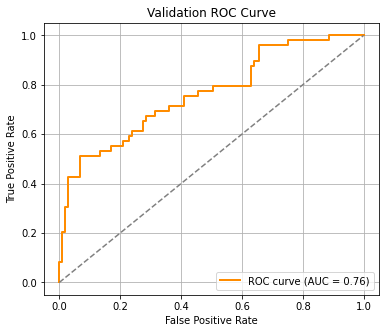

In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

def predict_and_plot(model, inputs, targets, name=''):
    preds = model.predict(inputs)
    
    probas = model.predict_proba(inputs)[:, 1]
        
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(targets, probas)
    auc_score = roc_auc_score(targets, probas)
    
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    
    # ROC Curve & AUC
    fpr, tpr, thresholds = roc_curve(targets, probas)
    auc_score = roc_auc_score(targets, probas)
    
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    return preds

# Predict and plot on the training data
train_preds = predict_and_plot(log_reg, X_train, y_train, 'Train')

# Predict and plot on the validation data
val_preds = predict_and_plot(log_reg, X_test, y_test, 'Validation')

In [57]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
model_2 = RandomForestClassifier(n_jobs =-1, random_state = 42)
model_2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [58]:
model_2.score(X_train,y_train)

1.0

Accuracy: 100.00%


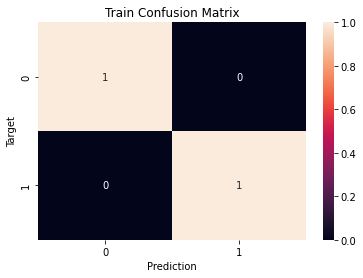

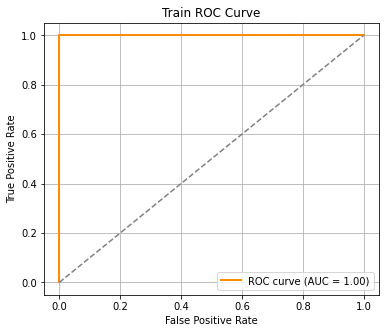

Accuracy: 76.62%


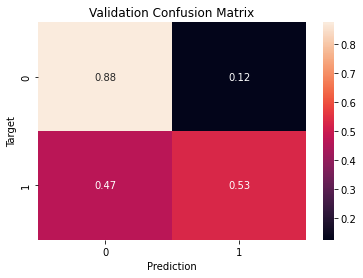

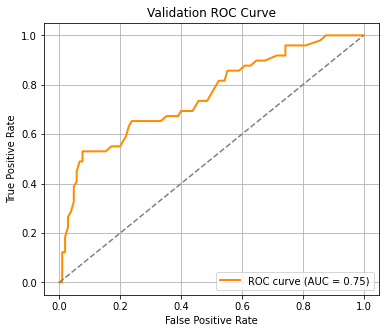

In [59]:
train_preds = predict_and_plot(model_2, X_train, y_train, 'Train')

# Predict and plot on the validation data
val_preds = predict_and_plot(model_2, X_test, y_test, 'Validation')

In [60]:
#Hyperparameter Tuning of Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [10, 20, 30],  # Adjust the number of trees in the forest
    'max_depth': [10, 20, 30],  # Adjust the maximum depth of each tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Adjust the minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 6, 8]  # Adjust the minimum samples required in a leaf node
}

model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the training and validation data
train_accuracy = best_model.score(X_train, y_train)
val_accuracy = best_model.score(X_test, y_test)

# Print the results
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 0.8664495114006515
Validation Accuracy: 0.7597402597402597


In [61]:
#************Hyperparameter Tuning of Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [10, 20, 30],  # Adjust the number of trees in the forest
    'max_depth': [10, 20, 30],  # Adjust the maximum depth of each tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Adjust the minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 6, 8]  # Adjust the minimum samples required in a leaf node
}

model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the training and validation data
train_accuracy = best_model.score(X_train, y_train)
val_accuracy = best_model.score(X_test, y_test)

# Print the results
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 0.8664495114006515
Validation Accuracy: 0.7597402597402597


In [62]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

decision_tree_model = DecisionTreeClassifier(random_state=42)

decision_tree_model.fit(X_train, y_train)

train_accuracy = decision_tree_model.score(X_train, y_train)
val_accuracy = decision_tree_model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 1.0
Validation Accuracy: 0.6623376623376623


In [63]:
#Hyperparameter Tuning Of Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 3, 5, 7],
    'criterion': ['gini', 'entropy']  # Add criterion hyperparameter
}

decision_tree_model = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

train_accuracy = best_model.score(X_train, y_train)
val_accuracy = best_model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 0.8664495114006515
Validation Accuracy: 0.6688311688311688


Training Accuracy: 0.8045602605863192
Validation Accuracy: 0.6688311688311688


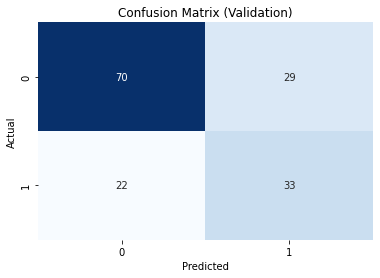

In [64]:

###KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

y_train_pred = knn_model.predict(X_train)

y_val_pred = knn_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

confusion = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation)')
plt.show()

In [65]:
###Hypertuning of KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9]  # Adjust the number of neighbors to explore
}

knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)

y_val_pred = best_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training Accuracy with Best Hyperparameters:", train_accuracy)
print("Validation Accuracy with Best Hyperparameters:", val_accuracy)

Training Accuracy with Best Hyperparameters: 0.7947882736156352
Validation Accuracy with Best Hyperparameters: 0.7272727272727273


Training Accuracy: 0.7785016286644951
Validation Accuracy: 0.7727272727272727


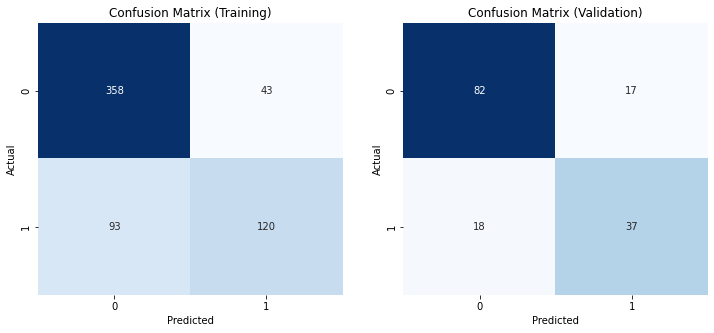

In [26]:
#Support Vector Classifier
from sklearn.svm import SVC
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)

y_train_pred = svm_model.predict(X_train)

y_val_pred = svm_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)

val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

train_confusion = confusion_matrix(y_train, y_train_pred)
val_confusion = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training)')

plt.subplot(1, 2, 2)
sns.heatmap(val_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation)')
plt.show()

In [66]:
#XGBOOST
from xgboost import XGBClassifier

# Create an XGBoost classifier
xgboost_model = XGBClassifier(n_estimators=100, max_depth=3, random_state=42)

# Fit the XGBoost model to the training data
xgboost_model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred_xgboost = xgboost_model.predict(X_train)

# Make predictions on the validation data
y_val_pred_xgboost = xgboost_model.predict(X_val)

# Calculate the training accuracy
train_accuracy_xgboost = accuracy_score(y_train, y_train_pred_xgboost)

# Calculate the validation accuracy
val_accuracy_xgboost = accuracy_score(y_val, y_val_pred_xgboost)

# Print the training and validation accuracies
print("XGBoost Training Accuracy:", train_accuracy_xgboost)
print("XGBoost Validation Accuracy:", val_accuracy_xgboost)

XGBoost Training Accuracy: 0.9185667752442996
XGBoost Validation Accuracy: 0.7467532467532467
